In [62]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import CamembertTokenizer

In [53]:
df_chunk = pd.read_csv('french_tweets.csv', chunksize=5)

In [60]:
n_tweets = 10000

lengths = []
for chunk in df_chunk:
    for tweet in chunk.text:
        lengths.append(len(tweet.split()))
    if len(lengths) >= n_tweets:
        break

10000 tweets


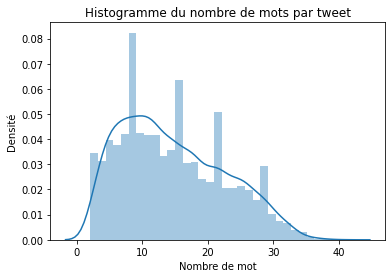

In [174]:
print(len(lengths), "tweets")
sns.distplot(lengths)
plt.title("Histogramme du nombre de mots par tweet")
plt.xlabel("Nombre de mot")
plt.ylabel("Densité")
plt.savefig(f'n_words_histogram_{len(lengths)}.png')
plt.show()

In [63]:
model_name = "camembert-base"
tokenizer = CamembertTokenizer.from_pretrained(model_name)

In [191]:
tweet = "Ceci est un exemple avec deux !!!?? fotes d'ortographe ⚽️⚾️ sans espace"

In [192]:
tokenizer.tokenize(tweet)

['▁Ceci',
 '▁est',
 '▁un',
 '▁exemple',
 '▁avec',
 '▁deux',
 '▁!!!',
 '??',
 '▁fo',
 'tes',
 '▁d',
 "'",
 'ort',
 'ographe',
 '▁',
 '⚽️⚾️',
 '▁sans',
 '▁espace']

In [197]:
tokenizer.tokenize('bhcuizehdeuz')

['▁b', 'h', 'cu', 'ize', 'h', 'de', 'uz']

In [190]:
tokenizer.decode(tokenizer.encode(tweet))

"<s> Ceci est un exemple avec deux!!!?? fotes d'ortographe <unk> sansespace</s>"

In [187]:
tokenizer.encode(tweet)

[5,
 2978,
 30,
 23,
 411,
 42,
 116,
 1309,
 6161,
 9557,
 1839,
 18,
 11,
 8607,
 18486,
 21,
 3,
 112,
 1179,
 6]

In [126]:
tokenizer.tokenize("ortographe")

['▁', 'ort', 'ographe']

In [125]:
tokenizer.encode('ortographe')

[5, 21, 8607, 18486, 6]

In [140]:
from spellchecker import SpellChecker

In [141]:
spell = SpellChecker(language='fr')

In [142]:
misspelled = ["resaissir", "matinnée", "plonbier", "tecnicien"]
misspelled = spell.unknown(misspelled)
for word in misspelled:
    print(word, spell.correction(word))

matinnée matinée
tecnicien technicien
resaissir ressaisir
plonbier plombier


In [158]:
spell.word_probability("un")

0.015231356190294348

In [159]:
spell.word_frequency.load_words(['testest'])

In [162]:
spell.correction("faut")

'faut'

In [171]:
'_rhume' in set(tokenizer.get_vocab().keys())

False

In [199]:
import spacy

In [206]:
nlp = spacy.load('fr')

In [208]:
list(nlp(tweet))

[Ceci,
 est,
 un,
 exemple,
 avec,
 deux,
 !,
 !,
 !,
 ?,
 ?,
 fotes,
 d',
 ortographe,
 ⚽,
 ️,
 ⚾,
 ️,
 sans,
 espace]